## Understand AI Bots on Social Media
## Data Analysis
## Fiona Fang

## Table of Contents
* [1. Basic overview of user_tweets column](#1.-Basic-overview-of-user_tweets-column)
* [2. Engagement: Do bots interact with mainly other bots or with human accounts?](#2.-Engagement:-Do-bots-interact-with-mainly-other-bots-or-with-human-accounts?)
* [3. Engagement: favorite & retweet counts](#3.-Engagement:-favorite-&-retweet-counts)
* [4. Do bots have more friends than followers?](#4.-Do-bots-have-more-friends-than-followers?)
* [5. How do bots and human post tweets?](#5.-How-do-bots-and-human-post-tweets?)
* [6. Do bots include more external URLs than humans?](#6.-Do-bots-include-more-external-URLs-than-humans?)
* [7. What about hashtags and user mentioned by bots?](#7.-What-about-hashtags-and-user-mentioned-by-bots?)
* [8. Word cloud: the most frequent-used words in the post](#8.-Word-cloud:-the-most-frequent-used-words-in-the-post)
* [9. Sentiment analysis](#9.-Sentiment-analysis) 

## Preparation


In [1]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from googletrans import Translator
from langdetect import detect
from textblob import TextBlob
from nltk.corpus import stopwords
from googletrans import Translator, LANGUAGES
from scipy.stats import cumfreq
from collections import Counter 
from urllib.parse import urlparse


In [2]:
# Import the dataset
data_path = '/Users/jiaying/Documents/DA_DSPP/Raw data/fox8_23_dataset.ndjson'
data = pd.read_json(data_path, lines=True)


The data includes information on 2280 Twitter accounts -- half of which belonged to humans and half to the bot network.

First half of the dataset is human-generated content, and the second half is the bot-generated content.

In [3]:
# First 5 rows
data.head(5)


,user_id,label,dataset,user_tweets
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te..."
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."


In [4]:
# Last 5 rows
data.tail(5)


,user_id,label,dataset,user_tweets
2275,1094461878,bot,fox8,"[{'contributors': None, 'truncated': False, 't..."
2276,729988381,bot,fox8,"[{'contributors': None, 'truncated': False, 't..."
2277,3105418328,bot,fox8,"[{'contributors': None, 'truncated': False, 't..."
2278,1093925310,bot,fox8,"[{'contributors': None, 'truncated': False, 't..."
2279,834229890,bot,fox8,"[{'contributors': None, 'truncated': False, 't..."


### Extracts the text from each tweet within the user_tweets list for further translation

In [5]:
# Function to extract text from tweet objects
# def extract_text(tweet):
#    try:
#        return tweet['text']
#    except KeyError:
#        return ""

# Extract text from tweets
# data['tweet_text'] = data['user_tweets'].apply(lambda tweets: [extract_text(tweet) for tweet in tweets])

# Flatten the list of tweet texts
# all_tweets = [text for sublist in data['tweet_text'] for text in sublist]

# Create a DataFrame with tweet texts
# tweet_df = pd.DataFrame({'tweet_text': all_tweets})

# Save the DataFrame to a CSV file
# tweet_df.to_csv('tweet_texts.csv', index=False)

# print("Tweet texts extracted and saved to 'tweet_texts.csv'")

## 1. Basic overview of user_tweets column

#### 1. Tweet Information:
- contributors: Information about contributors to the tweet, if any.
- truncated: Indicates if the tweet was truncated.
- text: The actual text content of the tweet.
- is_quote_status: Whether the tweet is quoting another tweet.
- in_reply_to_status_id: The ID of the original tweet if this tweet is a reply.
- id: The unique identifier for the tweet.
- favorite_count: The number of times the tweet has been favorited.
- source: The source from which the tweet was posted (e.g., Twitter Web Client).
- retweeted: Whether the tweet has been retweeted.
- coordinates: The geographical coordinates where the tweet was posted from, if available.

#### 2. entities: Contains various metadata about the tweet, including:
- symbols: Financial symbols (like $AAPL for Apple Inc.) mentioned in the tweet.
- user_mentions: Other users mentioned in the tweet.
- hashtags: Hashtags mentioned in the tweet.
- urls: URLs included in the tweet.
- in_reply_to_screen_name: The screen name of the user to whom the tweet is a reply.
- in_reply_to_user_id: The user ID of the original tweet if this tweet is a reply.
- retweet_count: The number of times the tweet has been retweeted.
- id_str: The string representation of the tweet ID.
- favorited: Whether the tweet has been favorited by the authenticating user.
- lang: The language of the tweet.
- Retweeted Status: If the tweet is a retweet, it includes a nested retweeted_status object containing similar variables as above for the original tweet.

#### 3. User Information: 
Inside both the main tweet object and the retweeted_status (if applicable), there's a user object that includes:
- id, id_str: The unique identifier for the user.
- name: The name of the user, as they’ve defined it.
- screen_name: The screen name, handle, or alias that this user identifies themselves with.
- location: The user-defined location for this account’s profile.
- description: The user-defined UTF-8 string describing their account.
- followers_count, friends_count, listed_count: The number of followers, friends, and lists the user is included in.
- created_at: The UTC datetime the account was created on Twitter.
- favourites_count: The number of tweets this user has liked in the account’s lifetime.
- utc_offset, time_zone: The UTC offset and time zone of the user's location.
- geo_enabled: Whether the user has enabled the possibility of geotagging their tweets.
- verified: Whether the user has a verified account.
- statuses_count: The number of tweets (including retweets) issued by the user.
- lang: The BCP 47 code for the user’s self-declared user interface language.
- profile_image_url_https, profile_background_image_url_https, profile_banner_url: URLs to the user's profile images and banner.

#### 4. Geographical Information:
- geo: Deprecated. The geographical location of this Tweet as reported by the user or client application.
- place: The specific place (if any) associated with the Tweet.

#### 5. Engagement and Interaction:
- possibly_sensitive: Whether the tweet contains sensitive content (if detectable).
- in_reply_to_status_id_str, in_reply_to_user_id_str: String representations of the original tweet's ID and user ID if this tweet is a reply.

In [6]:
# View the user_tweets column
tweet_content = data.at[1140, 'user_tweets'] # can change the row
# print(tweet_content)


In [7]:
# Extract the list of tweets for the first row
tweets_list = data.at[0, 'user_tweets'] # can change the row

# Separate each tweet and summarize the information
for tweet in tweets_list:
    print("Tweet Text:", tweet['text'])
    hashtags = [hashtag['text'] for hashtag in tweet['entities']['hashtags']]
    urls = [url['url'] for url in tweet['entities']['urls']]
    print("Hashtags:", hashtags)
    print("URLs:", urls)
    print("Favorite Count:", tweet['favorite_count'])
    print("Retweet Count:", tweet['retweet_count'])
    print("----")


Tweet Text: @christophkoeck In Diskussionen in D erlebe ich eine starke Tendenz, den fachwissenschaftlichen Teil des Studiums e… https://t.co/mnrFupSXIn
Hashtags: []
URLs: ['https://t.co/mnrFupSXIn']
Favorite Count: 0
Retweet Count: 0
----
Tweet Text: Zwei Lehrerinnen, zwölf Schüler und ein paar Schafe https://t.co/jTtda7l22s #EDchatDE #twitterlehrerzimmer
Hashtags: ['EDchatDE', 'twitterlehrerzimmer']
URLs: ['https://t.co/jTtda7l22s']
Favorite Count: 1
Retweet Count: 0
----
Tweet Text: Antisemitismus in Deutschland =&gt; Adam Armush: "Ich will mich nicht verstecken" https://t.co/CGx2FQAk1a
Hashtags: []
URLs: ['https://t.co/CGx2FQAk1a']
Favorite Count: 1
Retweet Count: 2
----
Tweet Text: Bayerische Politik und ihr Menschenbild – Das neue Psychiatriegesetz lässt tief in die Mentalität blicken, die da v… https://t.co/x7bkXVCN88
Hashtags: []
URLs: ['https://t.co/x7bkXVCN88']
Favorite Count: 0
Retweet Count: 1
----
Tweet Text: Es kommt doch auf den Lehrer an! #EDchatDE #Twitterlehrerzimmer


#### Some takeaways: 
1. Contain many posts for each accounts
2. Contain foreign language -- can use "lang" to detect

In [8]:
# Calculate the number of tweets in each account
data['tweet_count'] = data['user_tweets'].apply(len)
data.head(5)


,user_id,label,dataset,user_tweets,tweet_count
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te...",200
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",197
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",199


In [9]:
# Calculate total number of tweets
total_tweets = data['tweet_count'].sum()
print("Total number of tweets:", total_tweets)


Total number of tweets: 368028


## 2. Engagement: Do bots interact with mainly other bots or with human accounts?
About the interaction types: bots with bots, bots with humans, humans with bots, humans with humans

In [10]:
# Check if all user_id values are unique
are_user_ids_unique = data['user_id'].is_unique

print(f"User IDs are unique: {are_user_ids_unique}")


User IDs are unique: False


In [11]:
# Find an example user_id that appears more than once
duplicate_user_ids = data['user_id'].value_counts()[data['user_id'].value_counts() > 1].index.tolist()

if duplicate_user_ids:
    example_user_id = duplicate_user_ids[0]  # Take the first duplicate user_id as an example
    duplicate_rows = data[data['user_id'] == example_user_id]
    print(f"Example user_id with duplicates: {example_user_id}")
    print(duplicate_rows)
else:
    print("No duplicate user_ids found.")


Example user_id with duplicates: 304679484
       user_id  label             dataset  \
240  304679484  human  botometer-feedback   
396  304679484  human           gilani-17   

                                           user_tweets  tweet_count  
240  [{'contributors': None, 'truncated': False, 't...          200  
396  [{'created_at': 'Mon Jan 21 20:26:18 +0000 201...          200  


#### Some takeaways: 
Some user IDs appear multiple times in the dataset. For instance, the user ID 304679484 is present in both the 240th and 396th rows.

Upon investigation, it seems that this duplication occurs because the dataset combines several different sources. As a result, the same user ID may not consistently contain the same information in the user_tweet column.

### Interaction counts based on different types

Only replies and mentions provide user IDs, while favorites and retweets are solely quantified by their counts.

Thus, the analysis of engagement types here focuses on replies and mentions.

An example of mentions:
'entities': {'symbols': [], 'user_mentions': [{'id': 903233211374952448, 'indices': [0, 9], 'id_str': '903233211374952448', 'screen_name': 'FMPR2017', 'name': 'Franchise'}]

An example of replies:
'in_reply_to_user_id': 903233211374952448

In [12]:
# Initialize dictionaries to store interaction counts
mention_counts = {'bot_bot': 0, 'bot_human': 0, 'human_bot': 0, 'human_human': 0}
reply_counts = {'bot_bot': 0, 'bot_human': 0, 'human_bot': 0, 'human_human': 0}

# Function to extract and classify mentions and replies from a tweet
def classify_interactions(tweet, poster_label):
    # Extract mentioned user IDs
    mentioned_ids = [mention['id'] for mention in tweet.get('entities', {}).get('user_mentions', [])]
    for mentioned_id in mentioned_ids:
        mentioned_label = user_label_map.get(mentioned_id)
        if mentioned_label:  # If the mentioned user's label is known
            mention_counts[f"{poster_label}_{mentioned_label}"] += 1
    
    # Extract replied-to user IDs
    replied_to_id = tweet.get('in_reply_to_user_id')
    if replied_to_id:
        replied_to_label = user_label_map.get(replied_to_id)
        if replied_to_label:  # If the replied-to user's label is known
            reply_counts[f"{poster_label}_{replied_to_label}"] += 1

# Map user IDs to their labels (bot or human)
# user_label_map is a dictionary where the keys are user IDs and the the corresponding labels 
# This allows for quick lookups of user labels based on their ID
user_label_map = pd.Series(data.label.values, index=data.user_id).to_dict()

# Iterate through each user and their tweets
for index, row in data.iterrows():
    user_label = row['label']  # Label of the user posting the tweet
    for tweet in row['user_tweets']:
        classify_interactions(tweet, user_label)

# Calculate total interaction counts by adding mentions and replies
total_counts = {key: mention_counts[key] + reply_counts[key] for key in mention_counts.keys()}

# Output the results
print("Mention Counts:")
for interaction_type, count in mention_counts.items():
    print(f"{interaction_type}: {count}")

print("\nReply Counts:")
for interaction_type, count in reply_counts.items():
    print(f"{interaction_type}: {count}")

print("\nTotal Interaction Counts:")
for interaction_type, count in total_counts.items():
    print(f"{interaction_type}: {count}")


Mention Counts:
bot_bot: 8311
bot_human: 59
human_bot: 0
human_human: 9016

Reply Counts:
bot_bot: 2533
bot_human: 22
human_bot: 0
human_human: 4425

Total Interaction Counts:
bot_bot: 10844
bot_human: 81
human_bot: 0
human_human: 13441


#### Some takeaways:
1. When considering both mentions and replies, bots are involved in a significant number of interactions, with a total count of 10844.
2. Interactions between bots and humans are relatively low.
3. There are no recorded interactions between humans and bots. -- it means that human can effectively detct the content generated by bots?
4. The highest total interaction count is between humans, totaling 13441, showing a notable level of engagement within this group.

#### From the paper: 
"These findings suggest that the fox8 bots purposely... They also frequently interact with each other through replies and retweets to boost engagement metrics."

#### Possible policy implications:
1. Bot Behavior Regulation: The high number of interactions involving bots may warrant closer scrutiny or regulation of bot behavior, especially if these interactions are considered undesirable or potentially harmful.

2. Preventing Bot Manipulation: The absence of interactions between humans and bots may suggest that bots are not effectively engaging with or influencing human users. Policymakers could explore measures to prevent malicious or manipulative bot behavior that could potentially exploit or deceive human users.


## 3. Engagement: favorite & retweet counts

Favorites and retweets are solely quantified by their counts.

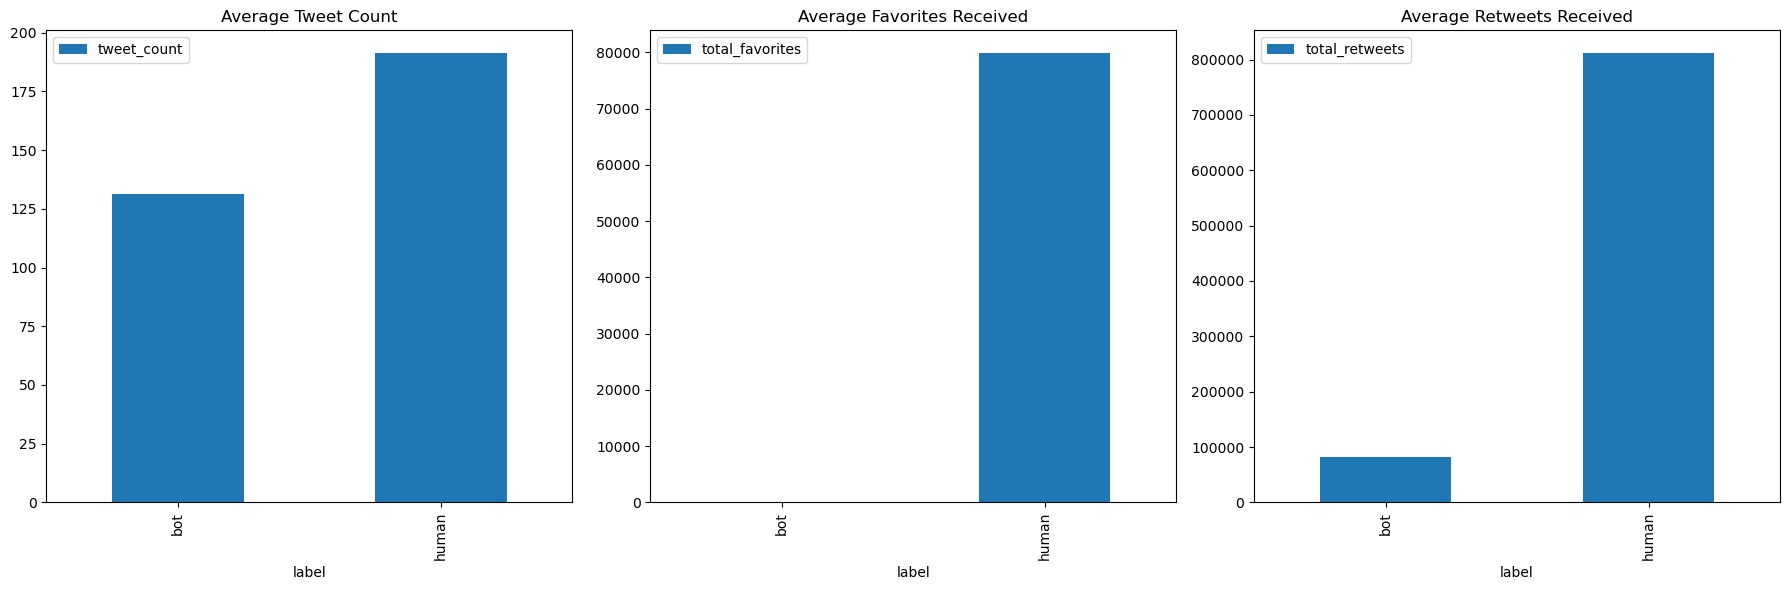

In [13]:
# Initialize lists to store aggregated data
user_ids, labels, tweet_counts, total_favorites, total_retweets = [], [], [], [], []

# Iterate through each account in the DataFrame
for index, row in data.iterrows():
    user_id = row['user_id']
    label = row['label']
    tweets = row['user_tweets']
    
    # Initialize counters for each account
    fav_count = 0
    rt_count = 0
    
    # Sum up favorite and retweet counts for each tweet
    for tweet in tweets:
        fav_count += tweet.get('favorite_count', 0)
        rt_count += tweet.get('retweet_count', 0)
    
    # Append aggregated data
    user_ids.append(user_id)
    labels.append(label)
    tweet_counts.append(len(tweets))
    total_favorites.append(fav_count)
    total_retweets.append(rt_count)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'user_id': user_ids,
    'label': labels,
    'tweet_count': tweet_counts,
    'total_favorites': total_favorites,
    'total_retweets': total_retweets
})

# Aggregate data by label
# Calculate the average values within each group
aggregated_data = summary_df.groupby('label').agg({
    'tweet_count': 'mean',
    'total_favorites': 'mean',
    'total_retweets': 'mean'
}).reset_index()

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for tweet counts
aggregated_data.plot(kind='bar', x='label', y='tweet_count', ax=axes[0], title='Average Tweet Count')

# Plot for total favorites
aggregated_data.plot(kind='bar', x='label', y='total_favorites', ax=axes[1], title='Average Favorites Received')

# Plot for total retweets
aggregated_data.plot(kind='bar', x='label', y='total_retweets', ax=axes[2], title='Average Retweets Received')

plt.tight_layout()
plt.show()


In [14]:
aggregated_data

,label,tweet_count,total_favorites,total_retweets
0,bot,131.388596,11.508772,81797.250877
1,human,191.442982,79928.094737,812351.510526


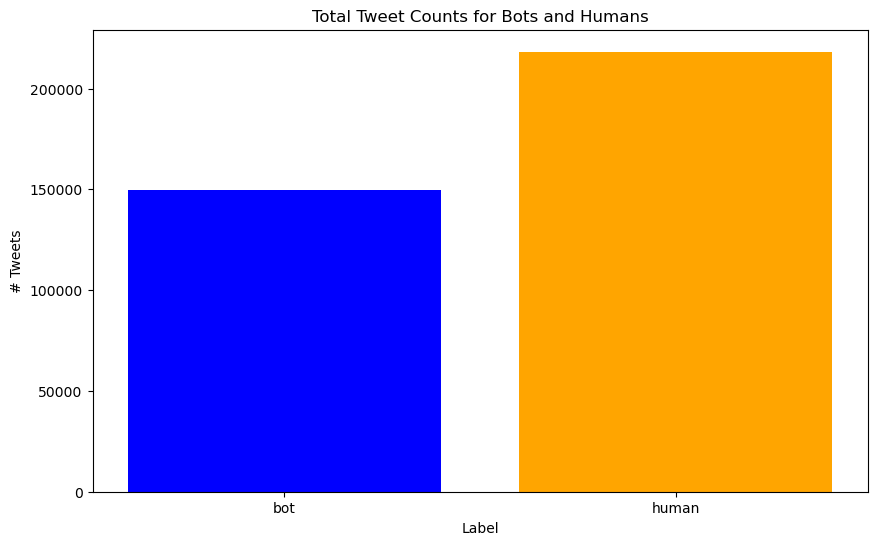

In [15]:
# Aggregate the total tweet counts for each label
total_tweet_counts = summary_df.groupby('label')['tweet_count'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for total tweet counts
plt.bar(total_tweet_counts['label'], total_tweet_counts['tweet_count'], color=['blue', 'orange'])

plt.xlabel('Label')
plt.ylabel('# Tweets')
plt.title('Total Tweet Counts for Bots and Humans')
plt.savefig(f'total_tweets.png', bbox_inches='tight')
plt.show()


In [16]:
total_tweet_counts


,label,tweet_count
0,bot,149783
1,human,218245


As for the favorites and retweets received, the number of human received is much larger than that of bots. Let's explore it.

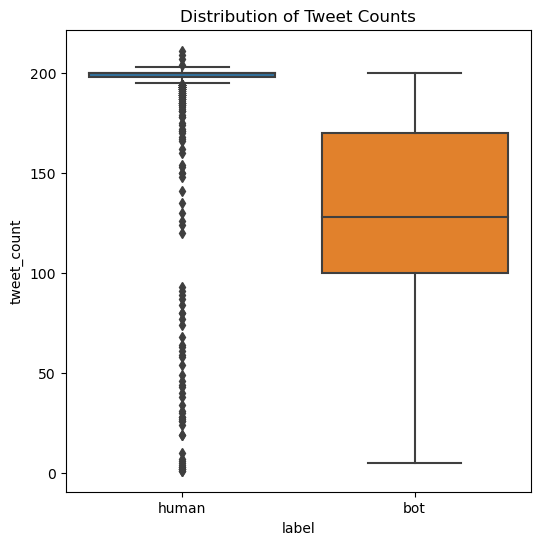

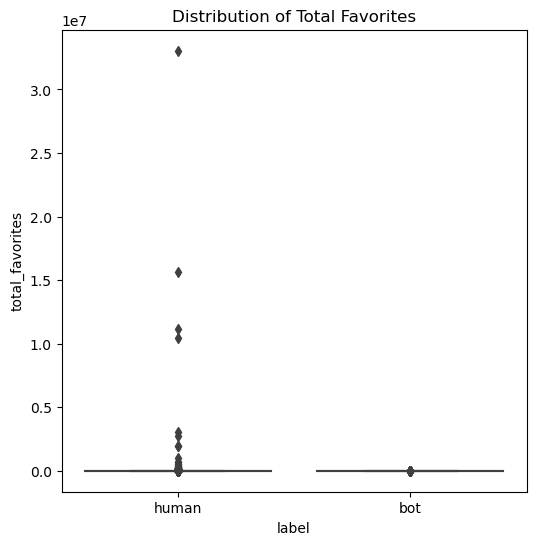

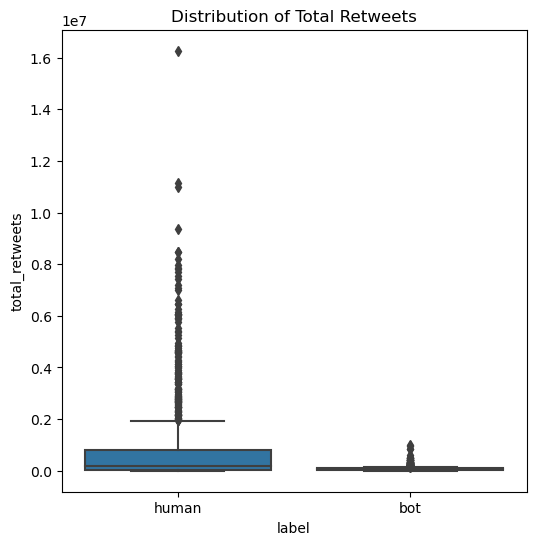

In [17]:
# Plot for tweet counts
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='tweet_count', data=summary_df)
plt.title('Distribution of Tweet Counts')
plt.show()

# Plot for total favorites
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='total_favorites', data=summary_df)
plt.title('Distribution of Total Favorites')
plt.show()

# Plot for total retweets
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='total_retweets', data=summary_df)
plt.title('Distribution of Total Retweets')
plt.show()

Data for total_favorites or total_retweets includes such extreme values, so I use a logarithmic scale to plot it again.

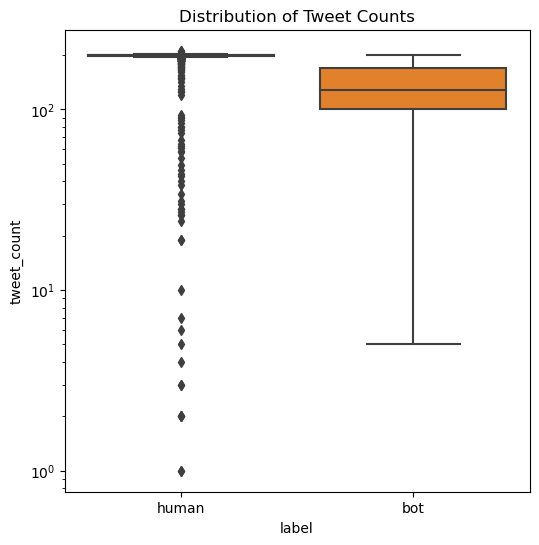

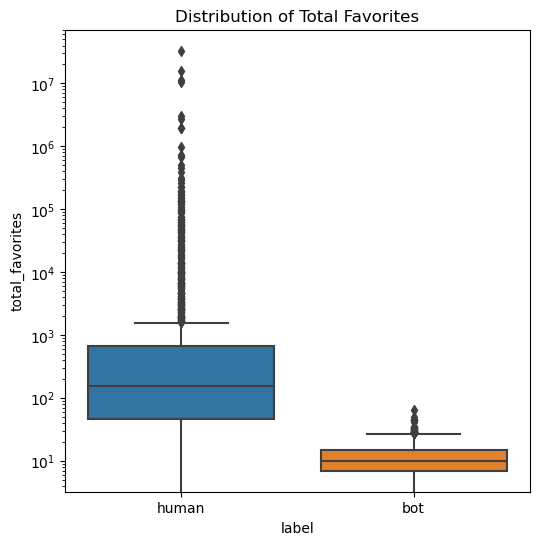

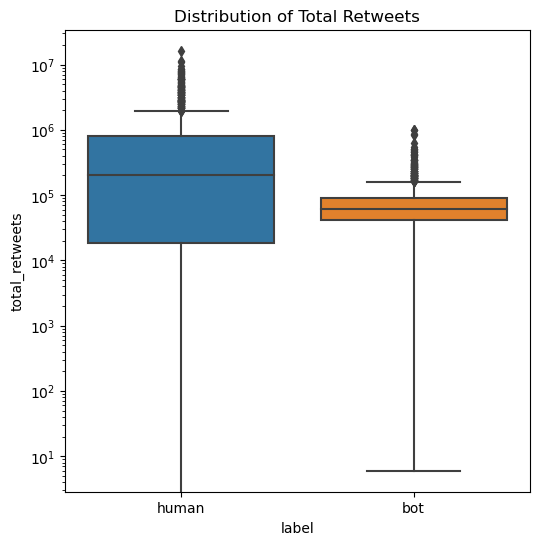

In [18]:
# Plot for tweet counts
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='tweet_count', data=summary_df)
plt.title('Distribution of Tweet Counts')
plt.yscale('log')  # Apply logarithmic scale
plt.savefig('tweet_counts_plot.png', bbox_inches='tight')  # Save the plot
plt.show()

# Plot for total favorites
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='total_favorites', data=summary_df)
plt.title('Distribution of Total Favorites')
plt.yscale('log')  # Apply logarithmic scale
plt.savefig('total_favorites_plot.png', bbox_inches='tight')  # Save the plot
plt.show()

# Plot for total retweets
plt.figure(figsize=(6, 6))
sns.boxplot(x='label', y='total_retweets', data=summary_df)
plt.title('Distribution of Total Retweets')
plt.yscale('log')  # Apply logarithmic scale
plt.savefig('total_retweets_plot.png', bbox_inches='tight')  # Save the plot
plt.show()

#### Some takeaways:
#### Observing more extreme values in tweet_count, total_favorites, and total_retweets for human accounts compared to bot accounts can imply several things:
1. Bot Behavior Nuance: The fact that bots do not exhibit as many extreme values as humans could indicate that bots are programmed for specific tasks (like spreading information, amplifying messages, etc.) with **a more uniform behavior pattern**. This can make them less detectable and more insidious in influencing discourse.
2. Variability and Influence: Human accounts likely exhibit greater variability in behavior and influence. High-impact users or influencers may have significantly higher engagement metrics due to their large followings or viral content, leading to extreme values in the dataset.
3. Network Effects: Human accounts might be more embedded within social networks, leading to more pronounced network effects where certain posts gain traction through shares, likes, and retweets more rapidly and extensively.
4. Content Resonance: Content from human accounts may resonate more deeply or widely with audiences, leading to higher engagement metrics. This could be due to the authentic, relatable, or timely nature of the content produced by humans.

#### Policy Implications:
1. Detection and Transparency: Policies should focus on improving the detection of bots and making their presence and activities transparent to users. This can help in understanding the extent of bot influence on social media dynamics.
2. Regulation of Bot Activities: Given bots' potential to manipulate discussions and spread misinformation, there's a need for clear guidelines and regulations governing bot behavior, ensuring they are used ethically and do not harm public discourse.
3. Accountability for Bot Creators: Holding creators of malicious bots accountable is crucial. Policies could require registration of automated accounts or impose penalties for using bots to engage in harmful activities.

## 4. Do bots have more friends than followers?

### Twitter accounts comparison in terms of followers and friends counts

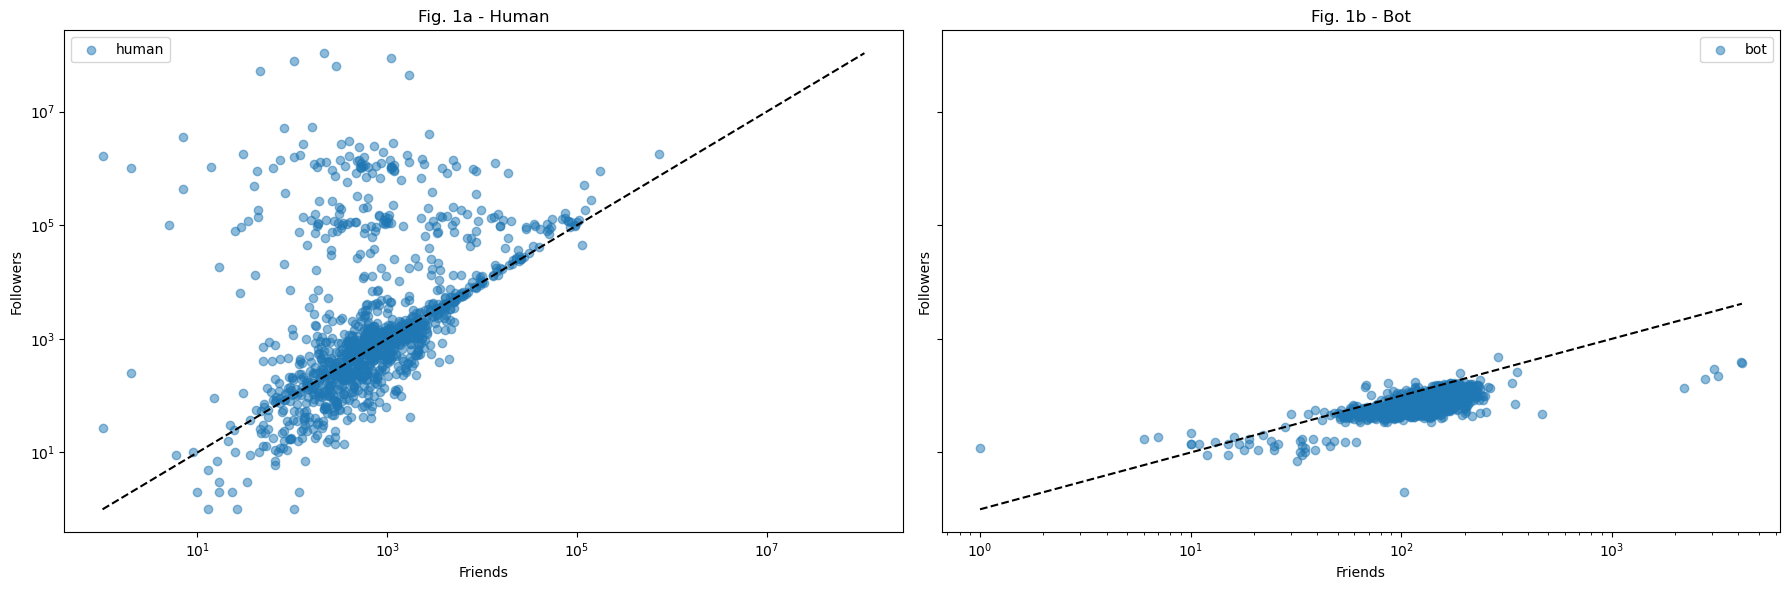

       followers_count  friends_count
label                                
bot          73.993860     140.495614
human    487837.295614    4168.938596


In [19]:
# Initialize lists to store followers and friends count
followers_counts = []
friends_counts = []

# Iterate over each row in the DataFrame to extract followers_count and friends_count
for index, row in data.iterrows():
    if row['user_tweets']:  # check if there is at least one tweet
        first_tweet = row['user_tweets'][0]  # get the first tweet
        user_info = first_tweet['user']  # get the user info from the first tweet
        followers_counts.append(user_info['followers_count'])
        friends_counts.append(user_info['friends_count'])
    else:
        # In case there are no tweets, append a None or a default value
        followers_counts.append(None)
        friends_counts.append(None)

# Add followers_count and friends_count to the DataFrame
data['followers_count'] = followers_counts
data['friends_count'] = friends_counts

# Calculate the mean of followers and friends for bots and humans
mean_values = data.groupby('label')[['followers_count', 'friends_count']].mean()

# Create a scatter plot
categories = data['label'].unique()
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for i, category in enumerate(categories):
    category_data = data[data['label'] == category]
    axes[i].scatter(category_data['friends_count'], category_data['followers_count'], alpha=0.5, label=category)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    max_count = max(category_data['friends_count'].max(), category_data['followers_count'].max())
    axes[i].plot([1, max_count], [1, max_count], 'k--')
    axes[i].set_xlabel('Friends')
    axes[i].set_ylabel('Followers')
    axes[i].set_title(f'Fig. 1{chr(97+i)} - {category.title()}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the mean values
print(mean_values)


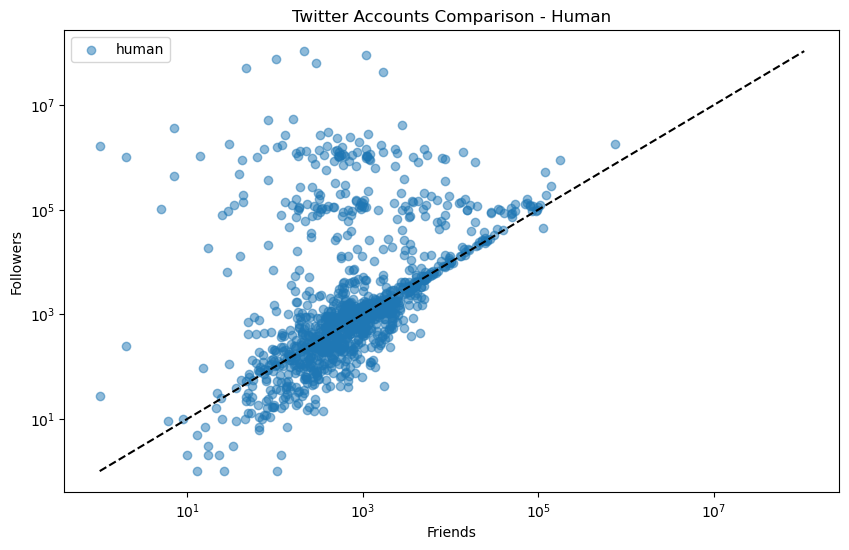

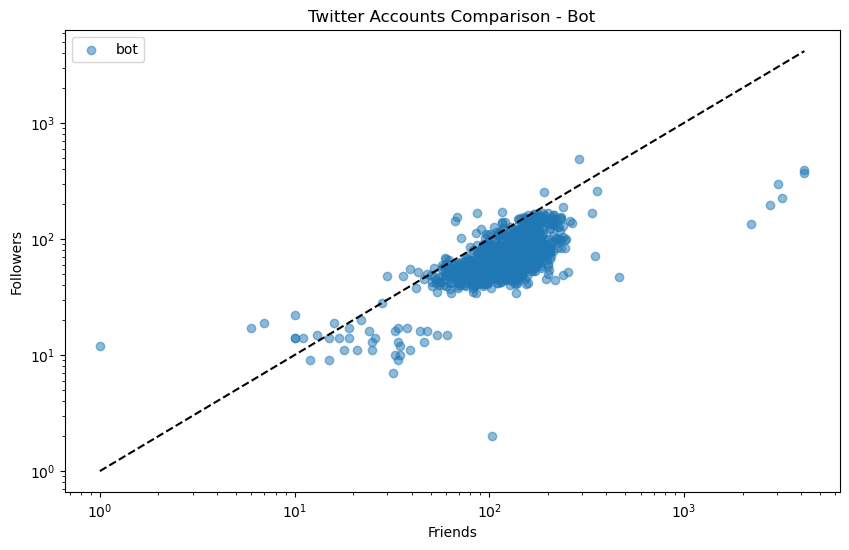

In [20]:
def extract_counts(tweets):
    if tweets and 'user' in tweets[0]:
        return tweets[0]['user']['followers_count'], tweets[0]['user']['friends_count']
    else:
        return None, None

# Apply the extraction to each row
data['followers_count'], data['friends_count'] = zip(*data['user_tweets'].apply(extract_counts))

# Drop rows where extraction was not possible
data.dropna(subset=['followers_count', 'friends_count'], inplace=True)

# Define categories
categories = data['label'].unique()

# Create separate scatter plots for each category
for i, category in enumerate(categories):
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    
    # Filter data for the category
    category_data = data[data['label'] == category]
    
    # Create scatter plot
    plt.scatter(category_data['friends_count'], category_data['followers_count'], alpha=0.5, label=category)
    
    # Log scale for better visibility
    plt.xscale('log')
    plt.yscale('log')

    # Diagonal line for reference
    max_count = max(category_data['friends_count'].max(), category_data['followers_count'].max())
    plt.plot([1, max_count], [1, max_count], 'k--')

    # Labels and title
    plt.xlabel('Friends')
    plt.ylabel('Followers')
    plt.title(f'Twitter Accounts Comparison - {category.title()}')  # Updated title
    plt.legend()

    # Save each plot with a category-specific name
    plt.savefig(f'followers_friends_{category}.png', bbox_inches='tight')

    # Show the plot
    plt.show()


#### Human Accounts: 

(1) The majority of human accounts cluster around the diagonal line, indicating a balance between the number of followers and friends. This implies that human relationships on Twitter are typically reciprocal—people tend to follow those who follow them (Mislove et al., 2007).

(2) The human data has a more widespread distribution, suggesting a greater variance in the ratio between friends and followers among human users.


#### Bot Accounts: 

(1) Bot accounts tend to have more friends than followers, clustering below the diagonal line. Bots follow many accounts, possibly in hopes of being followed back, but do not achieve a high number of followers in return.

(2) The bot data is more tightly clustered along the line, implying that bots may have a more uniform or predictable ratio of friends to followers. Also possibly due to Twitter’s limits on the follow-to-follower ratio as a means to suppress bot activity (Chu et al., 2012).

### Account Reputation

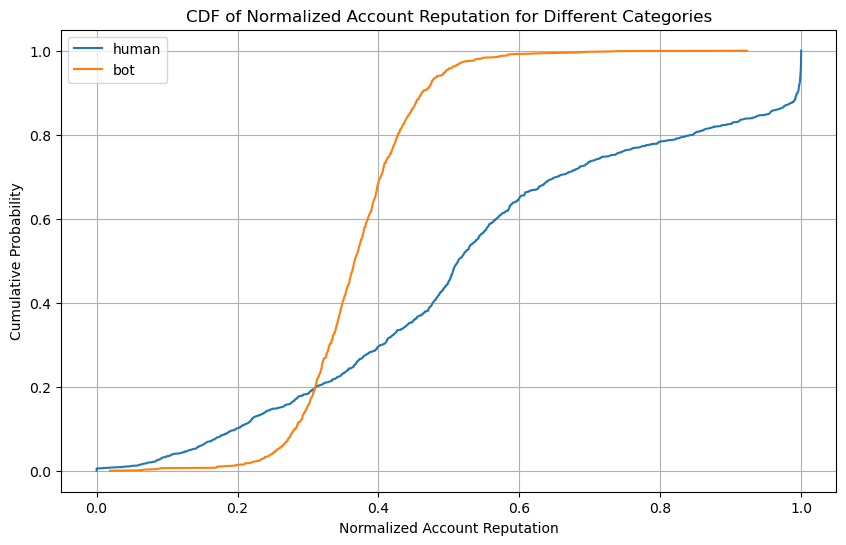

In [21]:
# Function to calculate Account Reputation
def calculate_account_reputation(row):
    follower_count = row['followers_count']
    friends_count = row['friends_count']
    if friends_count == 0:
        return 0  # Avoid division by zero
    return follower_count / (follower_count + friends_count)

# Calculate Account Reputation for each user
data['account_reputation'] = data.apply(calculate_account_reputation, axis=1)

# Normalize Account Reputation values
max_reputation = data['account_reputation'].max()
data['normalized_reputation'] = data['account_reputation'] / max_reputation

# Plot the CDF of normalized Account Reputation for each category
plt.figure(figsize=(10, 6))

for category in categories:
    category_data = data[data['label'] == category]
    reputation_values = category_data['normalized_reputation'].sort_values()
    cumulative_prob = np.linspace(0, 1, len(reputation_values))
    plt.plot(reputation_values, cumulative_prob, label=category)

plt.title('CDF of Normalized Account Reputation for Different Categories')
plt.xlabel('Normalized Account Reputation')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()


#### Some Takeaways: 

(1) Human accounts have a higher reputation score overall. A larger proportion of bot accounts have a lower reputation score.

(2) Bot accounts show a narrower distribution, implying a more uniform behavior, likely due to programmed actions. Human accounts display a broader distribution of followers to friends ratio. This spread indicates a variety of behaviors in how humans connect and are followed on social media (e.g., celebrity / influencer). 

## 5. How do bots and human post tweets?

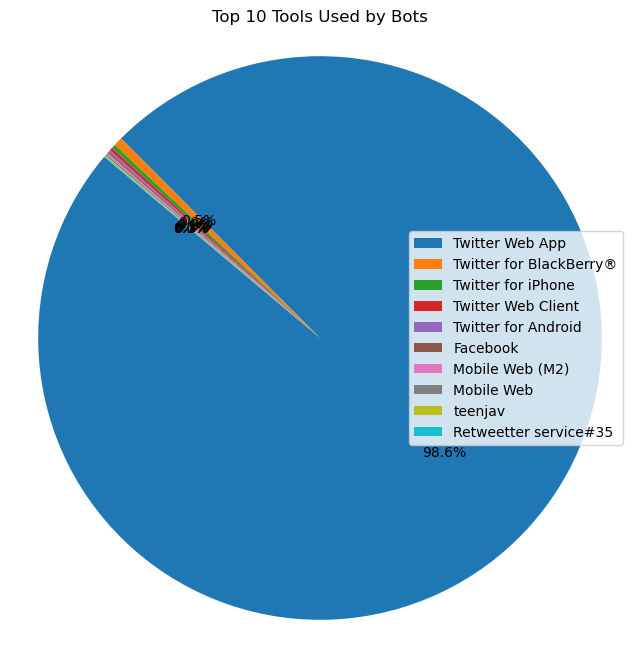

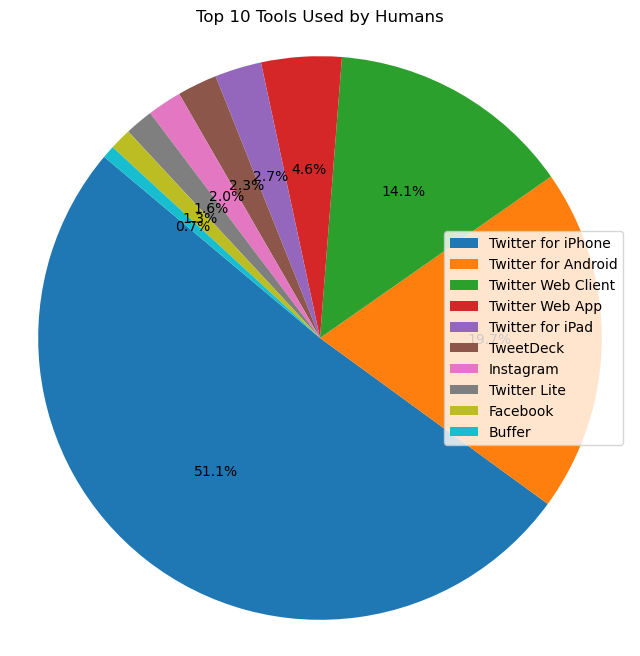

In [22]:
bot_sources = {}
human_sources = {}

# Iterate through each row in the 'user_tweets' column
for idx, tweet_list in enumerate(data['user_tweets']):
    # Get the label of the user for this row
    user_label = data['label'][idx]
    
    # Iterate through each tweet in the list
    for tweet in tweet_list:
        # Extract the source field from the tweet
        source = tweet['source']
        
        # Get the tweet ID
        tweet_id = tweet['id']
        
        # Extract the tool used from the source (it's between '>' and '<')
        tool = source.split('>')[1].split('<')[0]
        
        # Store the tool in the appropriate dictionary based on the user's label
        if user_label == 'bot':
            bot_sources[tweet_id] = tool
        else:
            human_sources[tweet_id] = tool

# Count the occurrences of tools for bots and humans
bot_tool_counts = Counter(bot_sources.values())
human_tool_counts = Counter(human_sources.values())

# Create DataFrames
bot_df = pd.DataFrame({'Tool': list(bot_tool_counts.keys()), 'Count': list(bot_tool_counts.values())})
human_df = pd.DataFrame({'Tool': list(human_tool_counts.keys()), 'Count': list(human_tool_counts.values())})

# Sort DataFrames by count and select top 10
bot_df = bot_df.sort_values(by='Count', ascending=False).head(10)
human_df = human_df.sort_values(by='Count', ascending=False).head(10)

# Function to plot pie chart without percentages and labels
def plot_pie_chart(tool_counts, title, filename):
    labels = tool_counts['Tool']
    sizes = tool_counts['Count']
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=['' for _ in labels], startangle=140, autopct='%1.1f%%')
    plt.title(title)
    plt.legend(labels, loc="best")
    plt.axis('equal')
    plt.savefig('how_they_post.png', dpi=300) 
    plt.show()

# Plot pie chart for bots and save the plot
plot_pie_chart(bot_df, 'Top 10 Tools Used by Bots', 'bots_pie_chart.png')

# Plot pie chart for humans and save the plot
plot_pie_chart(human_df, 'Top 10 Tools Used by Humans', 'humans_pie_chart.png')



In [23]:
print("Top 10 Tools Used by Bots:")
print(bot_df)

print("\nTop 10 Tools Used by Humans:")
print(human_df)


Top 10 Tools Used by Bots:
                       Tool   Count
0           Twitter Web App  147367
11  Twitter for BlackBerry®     760
9        Twitter for iPhone     349
2        Twitter Web Client     266
15      Twitter for Android     161
10                 Facebook     144
6           Mobile Web (M2)     138
7                Mobile Web     129
34                  teenjav      98
19    Retweetter service#35      68

Top 10 Tools Used by Humans:
                    Tool   Count
3     Twitter for iPhone  102294
4    Twitter for Android   39494
1     Twitter Web Client   28131
101      Twitter Web App    9219
0       Twitter for iPad    5367
2              TweetDeck    4581
26             Instagram    3933
6           Twitter Lite    3237
25              Facebook    2504
15                Buffer    1456


## 6. Do bots include more external URLs than humans?

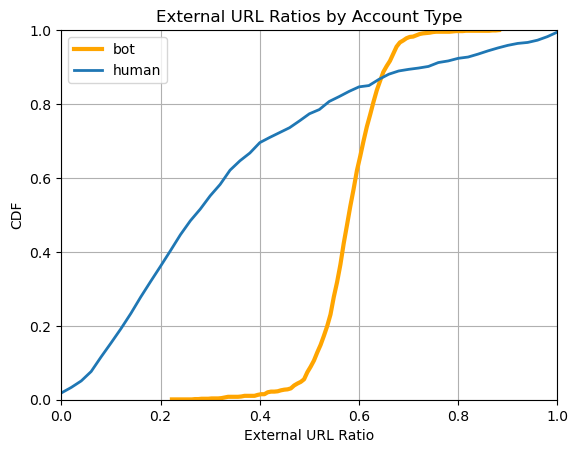

In [24]:
# Define a function to count URLs in the entities of tweets
def count_urls_in_entities(tweet_entities):
    return len(tweet_entities.get('urls', []))

# Extract the tweet entities and count the URLs for each tweet
def extract_and_count_urls(user_tweets_json):
    tweet_entities_list = [tweet.get('entities', {}) for tweet in user_tweets_json]
    url_counts = [count_urls_in_entities(entities) for entities in tweet_entities_list]
    return sum(url_counts)

# Apply the function to each user's tweets
data['url_count'] = data['user_tweets'].apply(extract_and_count_urls)

# Calculate the external URL ratio
data['url_ratio'] = data['url_count'] / data['tweet_count']

# Now, let's create the CDF plot
def plot_cdf(data, label_column, ratio_column, category):
    # Select the data for the category
    subset = data[data[label_column] == category]
    
    # Check if there's any data for the given category
    if len(subset) == 0:
        print(f"No data found for category: {category}")
        return
    
    # Calculate the CDF values
    values, base = np.histogram(subset[ratio_column], bins=100, density=True)
    cumulative = np.cumsum(values)
    
    # Plot the CDF with thicker line
    if category == 'bot':
        plt.plot(base[:-1], cumulative / cumulative[-1], label=category, linewidth=3, color='orange')
    else:
        plt.plot(base[:-1], cumulative / cumulative[-1], label=category, linewidth=2)

# Plot CDF for each category
categories = ['bot', 'human']
for category in categories:
    plot_cdf(data, 'label', 'url_ratio', category)

# Final plot formatting
plt.legend()
plt.xlabel('External URL Ratio')
plt.ylabel('CDF')
plt.grid(True)
plt.title('External URL Ratios by Account Type')
plt.xlim(0, 1)  # Adjust x-axis range if needed
plt.ylim(0, 1)  # Adjust y-axis range if needed

# Show the plot
plt.savefig('external_url_ratios_cdf.png', dpi=300)  
plt.show()


In [25]:
# Calculate the average URL ratio for humans and bots
average_url_ratio = data.groupby('label')['url_ratio'].mean()

# Print the results
print("Average URL Ratio for Humans:", average_url_ratio['human'])
print("Average URL Ratio for Bots:", average_url_ratio['bot'])


Average URL Ratio for Humans: 0.35452340012521405
Average URL Ratio for Bots: 0.5857409275911455


### The most frequent websites shared by accounts

In [26]:
def extract_domains(tweets):
    domains = []
    for tweet in tweets:
        # Extract urls from the 'entities' section of each tweet
        urls = tweet.get('entities', {}).get('urls', [])
        # Extract the domain from each url
        for url in urls:
            parsed_url = urlparse(url.get('expanded_url', ''))
            if parsed_url.netloc:  # Make sure it's a valid URL
                domains.append(parsed_url.netloc)
    return domains

# Test the function with a single entry
sample_tweets = data.loc[data['label'] == 'bot', 'user_tweets'].iloc[0]  # Adjust the filtering criteria as needed
sample_domains = extract_domains(sample_tweets)
print(sample_domains) 

if sample_domains:  # Proceed only if we get domains from the sample
    # Apply the function to the DataFrame and concatenate all lists of domains
    all_domains = sum(data[data['label'] == 'bot']['user_tweets'].apply(extract_domains), [])
    
    # Count the frequency of each domain
    domain_counts = Counter(all_domains)
    
    # Get the most common domains
    most_common_domains = domain_counts.most_common(11)  # Get top 11
    print(most_common_domains)

['cryptnomics.org', 'globaleconomics.news', 'twitter.com', 'www.aol.com', 'globaleconomics.news', 'www.merriam-webster.com', 'www.oxforddictionaries.com', 'news.yahoo.com', 'cryptnomics.org', 'cryptnomics.org', 'fox8.news', 'fox8.news', 'twitter.com', 'Stake.com', 'Stake.com', 'trib.al', 'twitter.com', 'www.investopedia.com', 'twitter.com', 'globaleconomics.news', 'twitter.com', 'globaleconomics.news', 'cryptnomics.org', 'cryptnomics.org', 'twitter.com', 'getyarn.io', 'fox8.news', 'cryptnomics.org', 'fox8.news', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'globaleconomics.news', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'globaleconomics.news', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'twitter.com', 'trib.al', 'twitter.com', 'twitter.com', 'globaleconomics.news', 'twitter.com', 'twitter.com', 'twitter.com', 'fox8.news', 'globaleconomics.news', 't

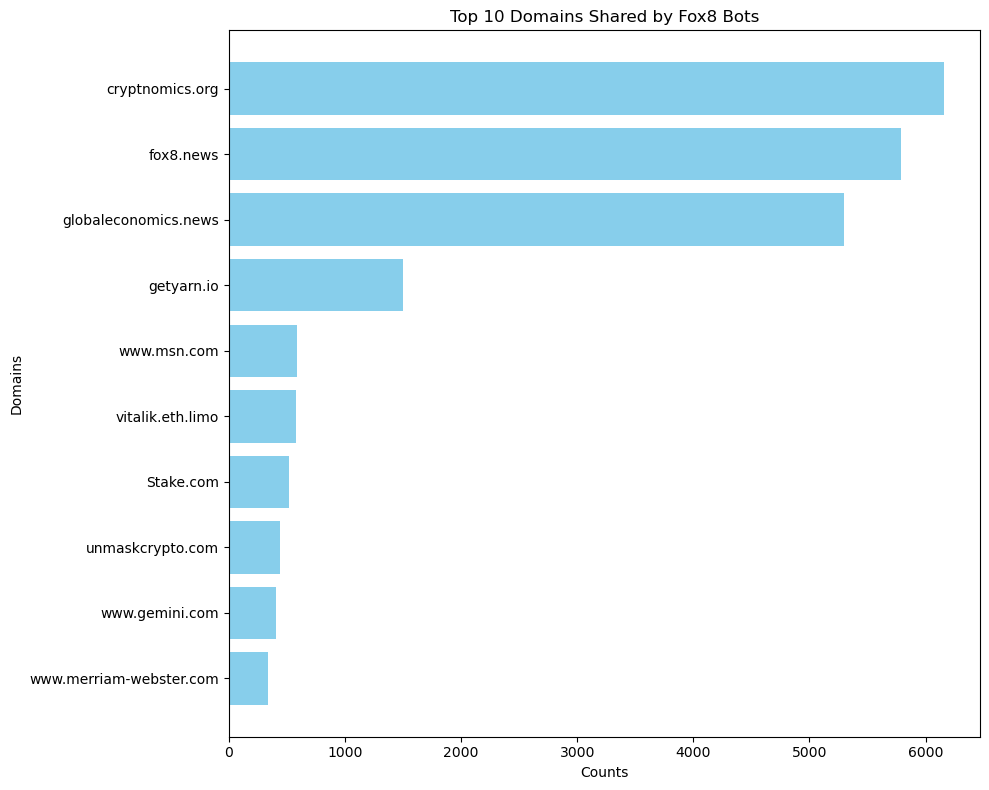

In [27]:
most_common_domains = domain_counts.most_common(11)[1:] 

# Unzip the domain names and their counts into two separate lists
domains, counts = zip(*most_common_domains)

# Create a bar chart
plt.figure(figsize=(10, 8))  # Set the figure size
plt.barh(domains, counts, color='skyblue')  # Create horizontal bar chart
plt.xlabel('Counts')  # Set the label for the x-axis
plt.ylabel('Domains')  # Set the label for the y-axis
plt.title('Top 10 Domains Shared by Fox8 Bots')  # Set the title of the chart
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest count on top
plt.tight_layout()  # Adjust the layout

# Display the chart
plt.savefig('Top 10 Domains Shared by Fox8 Bots.png', dpi=300)  
plt.show()


## 7. What about hashtags and user mentioned by bots?

In [28]:
def extract_hashtags(tweets):
    hashtags = []
    for tweet in tweets:
        # Extract hashtags from the 'entities' section of each tweet
        tweet_hashtags = tweet.get('entities', {}).get('hashtags', [])
        hashtags.extend([hashtag['text'] for hashtag in tweet_hashtags])
    return hashtags

def extract_user_mentions(tweets):
    user_mentions = []
    for tweet in tweets:
        # Extract user mentions from the 'entities' section of each tweet
        mentions = tweet.get('entities', {}).get('user_mentions', [])
        user_mentions.extend([mention['screen_name'] for mention in mentions])
    return user_mentions


In [29]:
# Apply the functions and flatten the results
fox8_bot_hashtags = sum(data['user_tweets'].apply(extract_hashtags), [])
fox8_bot_user_mentions = sum(data['user_tweets'].apply(extract_user_mentions), [])

# Count the frequencies
hashtag_counts = Counter(fox8_bot_hashtags)
user_mention_counts = Counter(fox8_bot_user_mentions)

# Get the ten most common hashtags and user mentions
most_common_hashtags = hashtag_counts.most_common(10)
most_common_user_mentions = user_mention_counts.most_common(10)


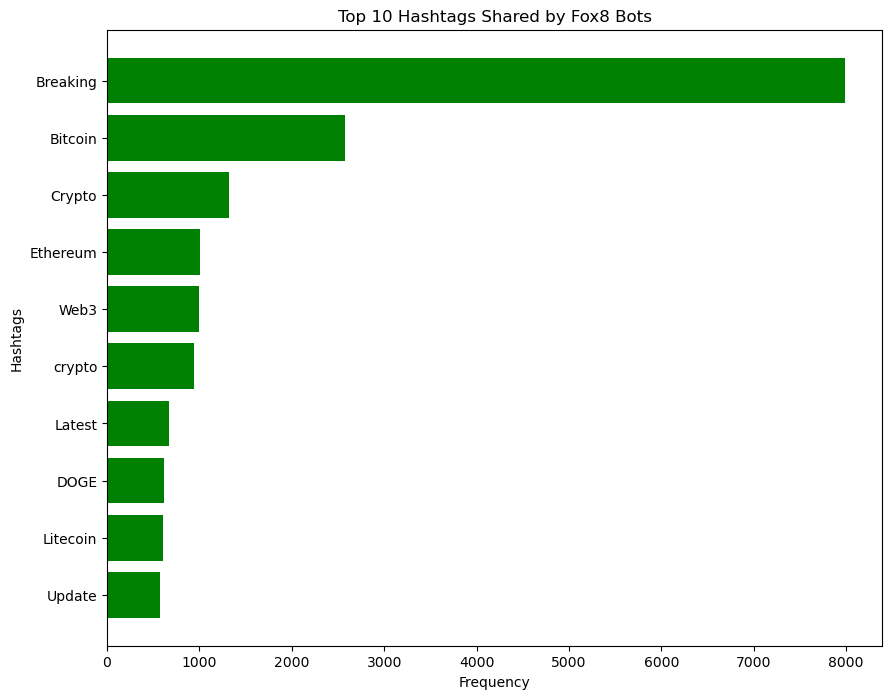

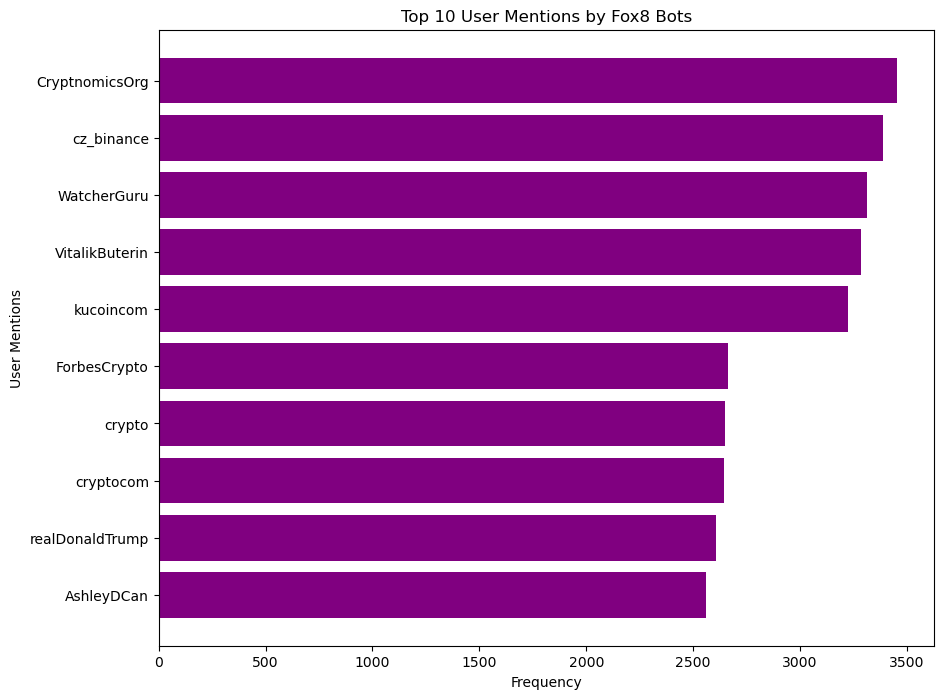

In [30]:
# Visualize the most common hashtags
hashtags, hashtag_freq = zip(*most_common_hashtags)
plt.figure(figsize=(10, 8))
plt.barh(hashtags, hashtag_freq, color='green')
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.title('Top 10 Hashtags Shared by Fox8 Bots')
plt.gca().invert_yaxis()
plt.savefig('Top 10 Hashtags Shared by Fox8 Bot.png', dpi=300)  
plt.show()

# Visualize the most common user mentions
user_mentions, mention_freq = zip(*most_common_user_mentions)
plt.figure(figsize=(10, 8))
plt.barh(user_mentions, mention_freq, color='purple')
plt.xlabel('Frequency')
plt.ylabel('User Mentions')
plt.title('Top 10 User Mentions by Fox8 Bots')
plt.gca().invert_yaxis()
plt.savefig('Top 10 User Mentions by Fox8 Bots.png', dpi=300)  
plt.show()


#### We can clearly see that the fox8 bots are mainly used to post and amplify information about cryptocurrency/blockchain.

I also try to look at the CDF, but the results are not strong.

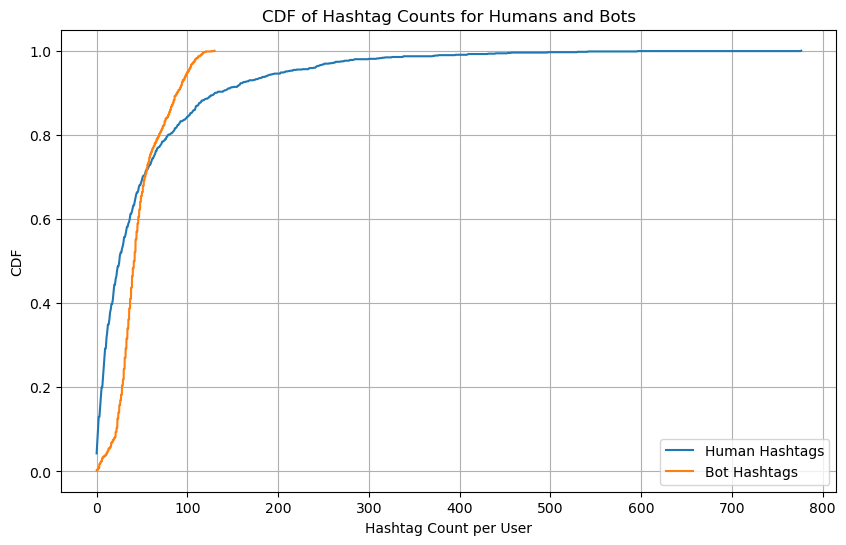

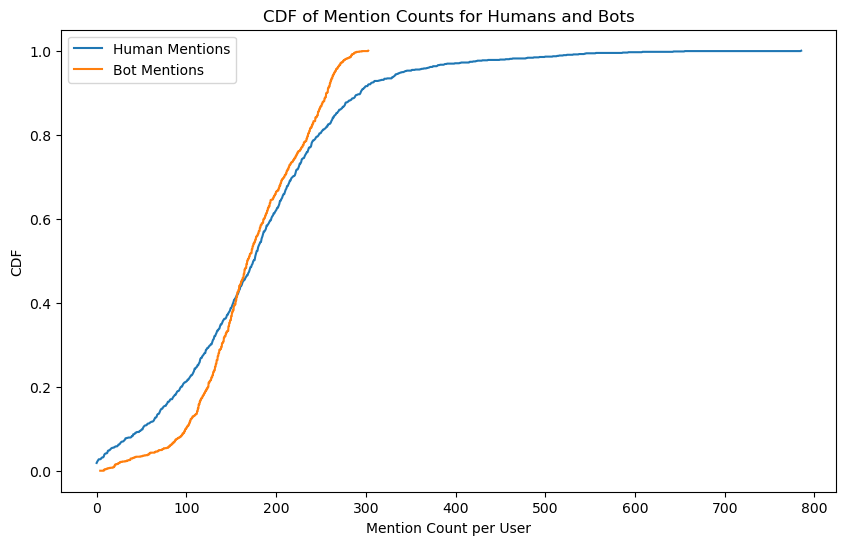

In [31]:
def count_hashtags(tweet):
    return len(tweet.get('entities', {}).get('hashtags', []))

def count_mentions(tweet):
    return len(tweet.get('entities', {}).get('user_mentions', []))

# Apply the count functions to each tweet for each user and calculate the total counts per user
data['hashtag_count'] = data['user_tweets'].apply(lambda tweets: sum(count_hashtags(tweet) for tweet in tweets))
data['mention_count'] = data['user_tweets'].apply(lambda tweets: sum(count_mentions(tweet) for tweet in tweets))

human_data = data[data['label'] == 'human']
bot_data = data[data['label'] == 'bot']

# Extract hashtag and mention counts for humans and bots
human_hashtag_counts = human_data['hashtag_count'].tolist()
human_mention_counts = human_data['mention_count'].tolist()

bot_hashtag_counts = bot_data['hashtag_count'].tolist()
bot_mention_counts = bot_data['mention_count'].tolist()

import numpy as np
import matplotlib.pyplot as plt

def plot_cdf(data, label):
    # Calculate the CDF
    values, base = np.histogram(data, bins=1000, density=True)
    cumulative = np.cumsum(values)
    # Plot the CDF
    plt.plot(base[:-1], cumulative / cumulative[-1], label=label)

# Plot CDF for hashtags
plt.figure(figsize=(10, 6))
plot_cdf(human_hashtag_counts, 'Human Hashtags')
plot_cdf(bot_hashtag_counts, 'Bot Hashtags')
plt.legend()
plt.xlabel('Hashtag Count per User')
plt.ylabel('CDF')
plt.title('CDF of Hashtag Counts for Humans and Bots')
plt.savefig('CDF of Hashtag Counts for Humans and Bots.png', dpi=300)  
plt.grid(True)
plt.show()

# Plot CDF for mentions
plt.figure(figsize=(10, 6))
plot_cdf(human_mention_counts, 'Human Mentions')
plot_cdf(bot_mention_counts, 'Bot Mentions')
plt.legend()
plt.xlabel('Mention Count per User')
plt.ylabel('CDF')
plt.title('CDF of Mention Counts for Humans and Bots')
plt.savefig('CDF of Mention Counts for Humans and Bots.png', dpi=300)  
plt.show()

## 8. Word cloud: the most frequent-used words in the post


### A basic one without preprocessing the text:

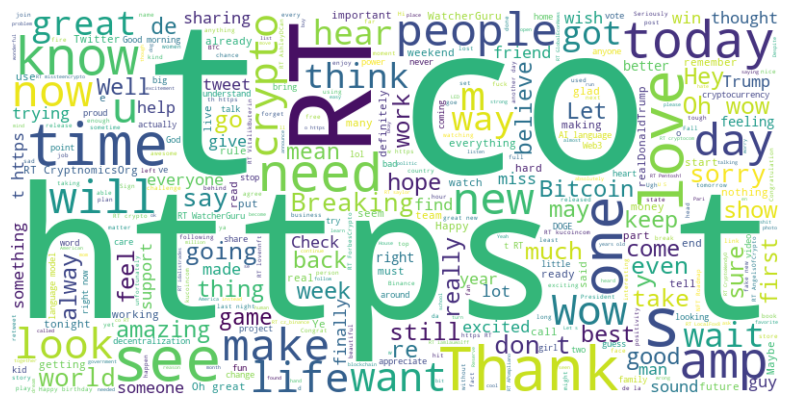

In [32]:
all_text = " ".join(tweet['text'] for tweet_list in data['user_tweets'] for tweet in tweet_list if 'text' in tweet)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=2000, width=800, height=400).generate(all_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Here it contain https. To improve the quality, we should remove URLs. Also, language of the text should also be taken into consideration.

### Scenario 1: Only English-language tweets

Preprocessing Text:
1. Filter for English Text: Use the lang attribute in each tweet to ensure only English-language tweets are processed.
2. Remove URLs, Mentions, and Hashtags: Clean the tweet text by removing unnecessary clutter that doesn't contribute to the analysis.
3. Remove Stopwords: Eliminate common English stopwords to focus on more meaningful words.

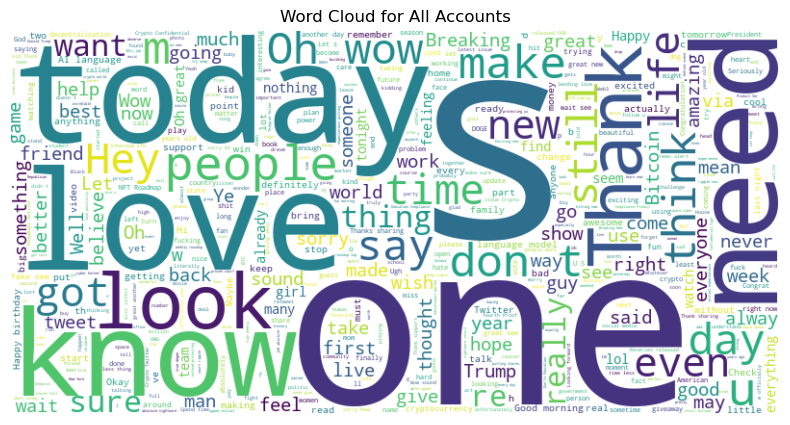

In [33]:
# Convert 'user_tweets' into a Series of lists of tweet dictionaries
tweets_series = pd.Series([tweet for tweet_list in data['user_tweets'] for tweet in tweet_list if tweet.get('lang') == 'en'])

# Extract text from each tweet and concatenate into a large string
all_texts = tweets_series.apply(lambda tweet: tweet['text']).str.cat(sep=' ')

# Define regex patterns for URLs, mentions, and hashtags
url_pattern = r'http\S+|www\S+|https\S+'
mention_hashtag_pattern = r'\@\w+|\#'

# Remove URLs, mentions, hashtags, and "&amp"
all_texts = re.sub(url_pattern, '', all_texts)
all_texts = re.sub(mention_hashtag_pattern, '', all_texts)
all_texts = all_texts.replace("&amp", "")

# Remove stopwords including 'RT' (case-insensitive)
stop_words = set(stopwords.words('english'))
stop_words.add('rt')  # Adding 'rt' to stopwords
all_texts = ' '.join([word for word in all_texts.split() if word.lower() not in stop_words])

# Generate the word cloud
wordcloud = WordCloud(background_color="white", max_words=2000, width=800, height=400).generate(all_texts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Accounts')
plt.axis("off")
plt.show()


#### Create separate word clouds for human and bot accounts

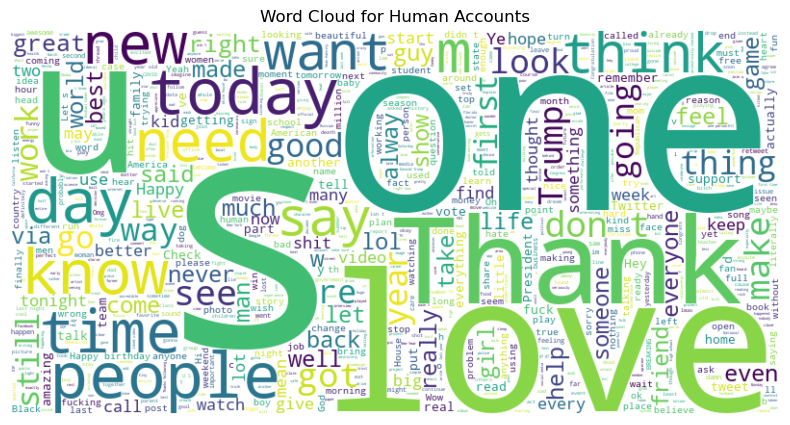

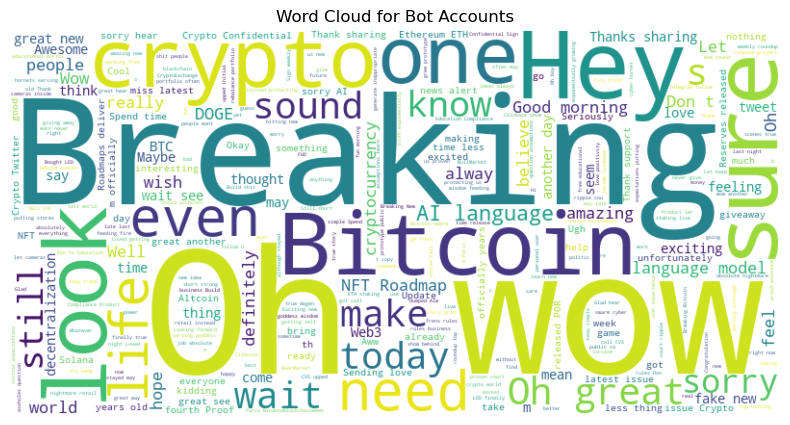

In [34]:
def preprocess_text(text):
    # Remove URLs, mentions, hashtags, "RT", and "&amp"
    text = re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#|\bRT\b|&amp', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Separate tweets by label
human_tweets = " ".join(preprocess_text(tweet['text']) for index, row in data.iterrows() if row['label'] == 'human' for tweet in row['user_tweets'] if tweet.get('lang') == 'en')
bot_tweets = " ".join(preprocess_text(tweet['text']) for index, row in data.iterrows() if row['label'] == 'bot' for tweet in row['user_tweets'] if tweet.get('lang') == 'en')

# Generate and display the word cloud for human accounts
human_wordcloud = WordCloud(background_color="white", max_words=2000, width=800, height=400).generate(human_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(human_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Human Accounts')
plt.axis("off")
plt.show()

# Generate and display the word cloud for bot accounts
bot_wordcloud = WordCloud(background_color="white", max_words=2000, width=800, height=400).generate(bot_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(bot_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Bot Accounts')
plt.axis("off")
plt.show()

### Scenario 2: Translate to English and Create Word Cloud

Steps:
1. Translate all non-English tweet texts into English
2. Preprocess Text
3. Create Word Cloud

In [35]:
# translator = Translator()

# def translate_text(text, lang):
#    try:
#        if lang != 'en' and lang in LANGUAGES:
#            return translator.translate(text, src=lang, dest='en').text
#       return text
#    except Exception as e:
#        return text  # Return the original text if translation fails

# Apply translation to each tweet
# for index, row in data.iterrows():
#    for tweet in row['user_tweets']:
#        tweet_lang = tweet.get('lang', 'en')
#        tweet['text'] = translate_text(tweet['text'], tweet_lang)

## 9. Sentiment analysis 

Are bot tweets more/less negative than human tweets? Are bots harassing human users?

### Original text

In [36]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/jiaying/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiaying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiaying/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
# Function to clean a tweet
def clean_tweet(tweet):
    tweet = tweet.lower()  # Lowercasing
    tweet = re.sub(r"http\S+|www\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\w+", "", tweet)  # Remove mentions
    tweet = re.sub(r"#\w+", "", tweet)  # Remove hashtags
    tweet = re.sub(r"&amp;", "and", tweet)  # Replace &amp; with 'and'
    tweet = re.sub(r"\bRT\b", "", tweet)  # Remove RT (retweet symbol)
    tweet = re.sub(r"[^a-zA-Z\s]", "", tweet)  # Remove special characters

    # Removing stopwords
    stopwords_set = set(stopwords.words('english'))
    tokens = tweet.split()
    tokens = [token for token in tokens if token not in stopwords_set]

    # Return the cleaned tweet as a string
    return ' '.join(tokens)

# Function to get sentiment of a tweet
def get_tweet_sentiment(tweet_text):
    cleaned_tweet = clean_tweet(tweet_text)
    analysis = TextBlob(cleaned_tweet)
    return analysis.sentiment.polarity  # Polarity score

# Add a new column to the DataFrame for sentiment scores
data['sentiment'] = data['user_tweets'].apply(lambda tweets: [get_tweet_sentiment(tweet['text']) for tweet in tweets])

# Calculate the average sentiment for each account
data['average_sentiment'] = data['sentiment'].apply(lambda sentiment_list: sum(sentiment_list) / len(sentiment_list) if len(sentiment_list) > 0 else 0)

# Separate DataFrames for bots and humans
bots = data[data['label'] == 'bot']
humans = data[data['label'] == 'human']

# Calculate average sentiment scores
average_bot_sentiment = bots['average_sentiment'].mean()
average_human_sentiment = humans['average_sentiment'].mean()

print(f"Average Bot Sentiment: {average_bot_sentiment}")
print(f"Average Human Sentiment: {average_human_sentiment}")


Average Bot Sentiment: 0.12463425459954434
Average Human Sentiment: 0.07882806089466626


Can also remove non-English text if necessary

#### The differences in language and word choice: 
Humans generally exhibite a more casual tone compared to the formal language often observed in bot-generated content. That's why bot is overall more positive in content.